# 6.4 Efficient GANの作成

- 本ファイルでは、Efficient GANのネットワークを実装し、学習をします。


# 6.4 学習目標

1.	Efficient GANを実装し、手書き数字画像で異常検知が生成できる

# 事前準備
書籍の指示に従い、本章で使用するデータを用意します

In [ ]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [ ]:
# Setup seeds
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


# Generatorの実装



In [ ]:
class Generator(nn.Module):

    def __init__(self, z_dim=20):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1,
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)

        # 転置畳み込み層に入れるためにテンソルの形を整形
        out = out.view(z.shape[0], 128, 7, 7)
        out = self.layer3(out)
        out = self.last(out)

        return out


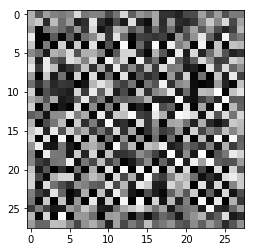

In [ ]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20)
G.train()

# 入力する乱数
# バッチノーマライゼーションがあるのでミニバッチ数は2以上
input_z = torch.randn(2, 20)

# 偽画像を出力
fake_images = G(input_z)  # torch.Size([2, 1, 28, 28])
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


# Discriminatorの実装

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()

        # 画像側の入力処理
        self.x_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        # 乱数側の入力処理
        self.z_layer1 = nn.Linear(z_dim, 512)

        # 最後の判定
        self.last1 = nn.Sequential(
            nn.Linear(3648, 1024),
            nn.LeakyReLU(0.1, inplace=True))

        self.last2 = nn.Linear(1024, 1)

    def forward(self, x, z):

        # 画像側の入力処理
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)

        # 乱数側の入力処理
        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)

        # x_outとz_outを結合し、全結合層で判定
        x_out = x_out.view(-1, 64 * 7 * 7)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)

        feature = out  # 最後にチャネルを1つに集約する手前の情報
        feature = feature.view(feature.size()[0], -1)  # 2次元に変換

        out = self.last2(out)

        return out, feature


In [ ]:
# 動作確認
D = Discriminator(z_dim=20)

# 偽画像を生成
input_z = torch.randn(2, 20)
fake_images = G(input_z)

# 偽画像をDに入力
d_out, _ = D(fake_images, input_z)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))


tensor([[0.4976],
        [0.4939]], grad_fn=<SigmoidBackward>)


# Encoderの実装

画像をzに変換する

In [ ]:
class Encoder(nn.Module):

    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3,
                      stride=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True))

        # ここまでで画像のサイズは7×7になっている
        self.last = nn.Linear(128 * 7 * 7, z_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        # FCに入れるためにテンソルの形を整形
        out = out.view(-1, 128 * 7 * 7)
        out = self.last(out)

        return out


In [ ]:
# 動作確認
E = Encoder(z_dim=20)

# 入力する画像データ
x = fake_images  # fake_imagesは上のGで作成したもの

# 画像からzをEncode
z = E(x)

print(z.shape)
print(z)


torch.Size([2, 20])
tensor([[-0.2117, -0.3586,  0.1473, -0.1527, -0.0279, -0.2314, -0.0856, -0.2432,
          0.0342,  0.1805,  0.0172, -0.0165,  0.1778,  0.3555,  0.2951, -0.3447,
         -0.3518, -0.1325, -0.0354, -0.2111],
        [-0.1011,  0.2350,  0.0888, -0.2578,  0.1728,  0.3983,  0.1063, -0.1835,
         -0.0881,  0.1863,  0.2127, -0.1049,  0.0425,  0.0202,  0.2042, -0.2098,
          0.1348, -0.1092, -0.3779, -0.2373]], grad_fn=<AddmmBackward>)


# DataLoaderの作成

In [ ]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./data/img_78_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


In [ ]:
class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


In [ ]:
class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed


In [ ]:
# DataLoaderの作成と動作確認

# ファイルリストを作成
train_img_list=make_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 28, 28])


# 学習させる

In [ ]:
# モデルを学習させる関数を作成


def train_model(G, D, E, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    # 誤差関数を定義
    # BCEWithLogitsLossは入力にシグモイド（logit）をかけてから、
    # バイナリークロスエントロピーを計算
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    E.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    E.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_e_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # ミニバッチサイズの1もしくは0のラベル役のテンソルを作成
            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # 真の画像を判定　
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. Encoderの学習
            # --------------------
            # 真の画像のzを推定
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 誤差を計算
            e_loss = criterion(d_out_real.view(-1), label_fake)

            # バックプロパゲーション
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

            # --------------------
            # 4. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    print("総イテレーション回数:", iteration)

    return G, D, E


In [ ]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        # 全結合層Linearの初期化
        m.bias.data.fill_(0)


# 初期化の実施
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")


ネットワークの初期化完了


In [ ]:
# 学習・検証を実行する
# 15分ほどかかる
num_epochs = 1500
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)


使用デバイス： cuda:0
-------------
Epoch 0/1500
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.1490 ||Epoch_G_Loss:0.0781 ||Epoch_E_Loss:0.0768
timer:  0.9127 sec.
-------------
Epoch 1/1500
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.1451 ||Epoch_G_Loss:0.0805 ||Epoch_E_Loss:0.0785
timer:  0.4236 sec.
-------------
Epoch 2/1500
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.1407 ||Epoch_G_Loss:0.0823 ||Epoch_E_Loss:0.0809
timer:  0.4263 sec.
-------------
Epoch 3/1500
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.1365 ||Epoch_G_Loss:0.0848 ||Epoch_E_Loss:0.0841
timer:  0.4250 sec.
-------------
Epoch 4/1500
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.1331 ||Epoch_G_Loss:0.0863 ||Epoch_E_Loss:0.0868
timer:  0.4236 sec.
-------------
Epoch 5/1500
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.1294 ||Epoch_G_Loss:0.0877 ||Epoch_E_Loss:0.0890
timer:  0.4248 sec.
-------------
Epoch 6/1500
----------

-------------
epoch 51 || Epoch_D_Loss:0.0129 ||Epoch_G_Loss:0.3426 ||Epoch_E_Loss:0.3360
timer:  0.4296 sec.
-------------
Epoch 52/1500
-------------
（train）
-------------
epoch 52 || Epoch_D_Loss:0.0129 ||Epoch_G_Loss:0.3523 ||Epoch_E_Loss:0.3418
timer:  0.4292 sec.
-------------
Epoch 53/1500
-------------
（train）
-------------
epoch 53 || Epoch_D_Loss:0.0106 ||Epoch_G_Loss:0.3523 ||Epoch_E_Loss:0.3650
timer:  0.4274 sec.
-------------
Epoch 54/1500
-------------
（train）
-------------
epoch 54 || Epoch_D_Loss:0.0105 ||Epoch_G_Loss:0.3572 ||Epoch_E_Loss:0.3642
timer:  0.4253 sec.
-------------
Epoch 55/1500
-------------
（train）
-------------
epoch 55 || Epoch_D_Loss:0.0101 ||Epoch_G_Loss:0.3595 ||Epoch_E_Loss:0.3754
timer:  0.4256 sec.
-------------
Epoch 56/1500
-------------
（train）
-------------
epoch 56 || Epoch_D_Loss:0.0087 ||Epoch_G_Loss:0.3768 ||Epoch_E_Loss:0.3977
timer:  0.4254 sec.
-------------
Epoch 57/1500
-------------
（train）
-------------
epoch 57 || Epoch_D_Loss:0

-------------
epoch 103 || Epoch_D_Loss:0.0389 ||Epoch_G_Loss:0.2903 ||Epoch_E_Loss:0.3237
timer:  0.4284 sec.
-------------
Epoch 104/1500
-------------
（train）
-------------
epoch 104 || Epoch_D_Loss:0.0520 ||Epoch_G_Loss:0.2650 ||Epoch_E_Loss:0.2816
timer:  0.4256 sec.
-------------
Epoch 105/1500
-------------
（train）
-------------
epoch 105 || Epoch_D_Loss:0.0804 ||Epoch_G_Loss:0.2246 ||Epoch_E_Loss:0.2261
timer:  0.4276 sec.
-------------
Epoch 106/1500
-------------
（train）
-------------
epoch 106 || Epoch_D_Loss:0.0669 ||Epoch_G_Loss:0.2189 ||Epoch_E_Loss:0.2451
timer:  0.4252 sec.
-------------
Epoch 107/1500
-------------
（train）
-------------
epoch 107 || Epoch_D_Loss:0.0579 ||Epoch_G_Loss:0.2306 ||Epoch_E_Loss:0.2647
timer:  0.4262 sec.
-------------
Epoch 108/1500
-------------
（train）
-------------
epoch 108 || Epoch_D_Loss:0.0629 ||Epoch_G_Loss:0.2690 ||Epoch_E_Loss:0.2621
timer:  0.4270 sec.
-------------
Epoch 109/1500
-------------
（train）
-------------
epoch 109 || E

-------------
epoch 154 || Epoch_D_Loss:0.0929 ||Epoch_G_Loss:0.1596 ||Epoch_E_Loss:0.1787
timer:  0.4261 sec.
-------------
Epoch 155/1500
-------------
（train）
-------------
epoch 155 || Epoch_D_Loss:0.1010 ||Epoch_G_Loss:0.1715 ||Epoch_E_Loss:0.1699
timer:  0.4248 sec.
-------------
Epoch 156/1500
-------------
（train）
-------------
epoch 156 || Epoch_D_Loss:0.1025 ||Epoch_G_Loss:0.1491 ||Epoch_E_Loss:0.1676
timer:  0.4244 sec.
-------------
Epoch 157/1500
-------------
（train）
-------------
epoch 157 || Epoch_D_Loss:0.1098 ||Epoch_G_Loss:0.1548 ||Epoch_E_Loss:0.1706
timer:  0.4247 sec.
-------------
Epoch 158/1500
-------------
（train）
-------------
epoch 158 || Epoch_D_Loss:0.1070 ||Epoch_G_Loss:0.1583 ||Epoch_E_Loss:0.1645
timer:  0.4268 sec.
-------------
Epoch 159/1500
-------------
（train）
-------------
epoch 159 || Epoch_D_Loss:0.0915 ||Epoch_G_Loss:0.1663 ||Epoch_E_Loss:0.1783
timer:  0.4258 sec.
-------------
Epoch 160/1500
-------------
（train）
-------------
epoch 160 || E

-------------
epoch 205 || Epoch_D_Loss:0.1144 ||Epoch_G_Loss:0.1385 ||Epoch_E_Loss:0.1391
timer:  0.4265 sec.
-------------
Epoch 206/1500
-------------
（train）
-------------
epoch 206 || Epoch_D_Loss:0.1105 ||Epoch_G_Loss:0.1335 ||Epoch_E_Loss:0.1395
timer:  0.4259 sec.
-------------
Epoch 207/1500
-------------
（train）
-------------
epoch 207 || Epoch_D_Loss:0.1172 ||Epoch_G_Loss:0.1623 ||Epoch_E_Loss:0.1339
timer:  0.4254 sec.
-------------
Epoch 208/1500
-------------
（train）
-------------
epoch 208 || Epoch_D_Loss:0.1146 ||Epoch_G_Loss:0.1114 ||Epoch_E_Loss:0.1431
timer:  0.4272 sec.
-------------
Epoch 209/1500
-------------
（train）
-------------
epoch 209 || Epoch_D_Loss:0.1484 ||Epoch_G_Loss:0.1176 ||Epoch_E_Loss:0.1145
timer:  0.4269 sec.
-------------
Epoch 210/1500
-------------
（train）
-------------
epoch 210 || Epoch_D_Loss:0.1496 ||Epoch_G_Loss:0.1111 ||Epoch_E_Loss:0.1165
timer:  0.4257 sec.
-------------
Epoch 211/1500
-------------
（train）
-------------
epoch 211 || E

-------------
epoch 256 || Epoch_D_Loss:0.1426 ||Epoch_G_Loss:0.1168 ||Epoch_E_Loss:0.1388
timer:  0.4276 sec.
-------------
Epoch 257/1500
-------------
（train）
-------------
epoch 257 || Epoch_D_Loss:0.1614 ||Epoch_G_Loss:0.1039 ||Epoch_E_Loss:0.1286
timer:  0.4248 sec.
-------------
Epoch 258/1500
-------------
（train）
-------------
epoch 258 || Epoch_D_Loss:0.1793 ||Epoch_G_Loss:0.0987 ||Epoch_E_Loss:0.1131
timer:  0.4257 sec.
-------------
Epoch 259/1500
-------------
（train）
-------------
epoch 259 || Epoch_D_Loss:0.1798 ||Epoch_G_Loss:0.0942 ||Epoch_E_Loss:0.1113
timer:  0.4251 sec.
-------------
Epoch 260/1500
-------------
（train）
-------------
epoch 260 || Epoch_D_Loss:0.1724 ||Epoch_G_Loss:0.1033 ||Epoch_E_Loss:0.1091
timer:  0.4260 sec.
-------------
Epoch 261/1500
-------------
（train）
-------------
epoch 261 || Epoch_D_Loss:0.1690 ||Epoch_G_Loss:0.0986 ||Epoch_E_Loss:0.1048
timer:  0.4257 sec.
-------------
Epoch 262/1500
-------------
（train）
-------------
epoch 262 || E

-------------
epoch 307 || Epoch_D_Loss:0.1501 ||Epoch_G_Loss:0.0967 ||Epoch_E_Loss:0.1281
timer:  0.4266 sec.
-------------
Epoch 308/1500
-------------
（train）
-------------
epoch 308 || Epoch_D_Loss:0.1863 ||Epoch_G_Loss:0.0861 ||Epoch_E_Loss:0.1052
timer:  0.4249 sec.
-------------
Epoch 309/1500
-------------
（train）
-------------
epoch 309 || Epoch_D_Loss:0.1618 ||Epoch_G_Loss:0.1051 ||Epoch_E_Loss:0.1151
timer:  0.4258 sec.
-------------
Epoch 310/1500
-------------
（train）
-------------
epoch 310 || Epoch_D_Loss:0.1370 ||Epoch_G_Loss:0.1150 ||Epoch_E_Loss:0.1318
timer:  0.4271 sec.
-------------
Epoch 311/1500
-------------
（train）
-------------
epoch 311 || Epoch_D_Loss:0.1516 ||Epoch_G_Loss:0.0973 ||Epoch_E_Loss:0.1186
timer:  0.4291 sec.
-------------
Epoch 312/1500
-------------
（train）
-------------
epoch 312 || Epoch_D_Loss:0.1473 ||Epoch_G_Loss:0.0925 ||Epoch_E_Loss:0.1175
timer:  0.4293 sec.
-------------
Epoch 313/1500
-------------
（train）
-------------
epoch 313 || E

-------------
epoch 358 || Epoch_D_Loss:0.1502 ||Epoch_G_Loss:0.0974 ||Epoch_E_Loss:0.1050
timer:  0.4295 sec.
-------------
Epoch 359/1500
-------------
（train）
-------------
epoch 359 || Epoch_D_Loss:0.1267 ||Epoch_G_Loss:0.1025 ||Epoch_E_Loss:0.1244
timer:  0.4300 sec.
-------------
Epoch 360/1500
-------------
（train）
-------------
epoch 360 || Epoch_D_Loss:0.1280 ||Epoch_G_Loss:0.1102 ||Epoch_E_Loss:0.1206
timer:  0.4266 sec.
-------------
Epoch 361/1500
-------------
（train）
-------------
epoch 361 || Epoch_D_Loss:0.1341 ||Epoch_G_Loss:0.1043 ||Epoch_E_Loss:0.1160
timer:  0.4277 sec.
-------------
Epoch 362/1500
-------------
（train）
-------------
epoch 362 || Epoch_D_Loss:0.1337 ||Epoch_G_Loss:0.0994 ||Epoch_E_Loss:0.1205
timer:  0.4271 sec.
-------------
Epoch 363/1500
-------------
（train）
-------------
epoch 363 || Epoch_D_Loss:0.1461 ||Epoch_G_Loss:0.1027 ||Epoch_E_Loss:0.1090
timer:  0.4269 sec.
-------------
Epoch 364/1500
-------------
（train）
-------------
epoch 364 || E

-------------
epoch 409 || Epoch_D_Loss:0.1394 ||Epoch_G_Loss:0.0945 ||Epoch_E_Loss:0.1105
timer:  0.4265 sec.
-------------
Epoch 410/1500
-------------
（train）
-------------
epoch 410 || Epoch_D_Loss:0.1600 ||Epoch_G_Loss:0.0958 ||Epoch_E_Loss:0.0967
timer:  0.4265 sec.
-------------
Epoch 411/1500
-------------
（train）
-------------
epoch 411 || Epoch_D_Loss:0.1463 ||Epoch_G_Loss:0.0956 ||Epoch_E_Loss:0.1072
timer:  0.4279 sec.
-------------
Epoch 412/1500
-------------
（train）
-------------
epoch 412 || Epoch_D_Loss:0.1381 ||Epoch_G_Loss:0.0934 ||Epoch_E_Loss:0.1122
timer:  0.4284 sec.
-------------
Epoch 413/1500
-------------
（train）
-------------
epoch 413 || Epoch_D_Loss:0.1543 ||Epoch_G_Loss:0.0921 ||Epoch_E_Loss:0.0969
timer:  0.4268 sec.
-------------
Epoch 414/1500
-------------
（train）
-------------
epoch 414 || Epoch_D_Loss:0.1706 ||Epoch_G_Loss:0.0800 ||Epoch_E_Loss:0.0927
timer:  0.4250 sec.
-------------
Epoch 415/1500
-------------
（train）
-------------
epoch 415 || E

-------------
epoch 460 || Epoch_D_Loss:0.1503 ||Epoch_G_Loss:0.1036 ||Epoch_E_Loss:0.1127
timer:  0.4232 sec.
-------------
Epoch 461/1500
-------------
（train）
-------------
epoch 461 || Epoch_D_Loss:0.1617 ||Epoch_G_Loss:0.0944 ||Epoch_E_Loss:0.1078
timer:  0.4257 sec.
-------------
Epoch 462/1500
-------------
（train）
-------------
epoch 462 || Epoch_D_Loss:0.1647 ||Epoch_G_Loss:0.0844 ||Epoch_E_Loss:0.1038
timer:  0.4257 sec.
-------------
Epoch 463/1500
-------------
（train）
-------------
epoch 463 || Epoch_D_Loss:0.1697 ||Epoch_G_Loss:0.0838 ||Epoch_E_Loss:0.0986
timer:  0.4261 sec.
-------------
Epoch 464/1500
-------------
（train）
-------------
epoch 464 || Epoch_D_Loss:0.1739 ||Epoch_G_Loss:0.0770 ||Epoch_E_Loss:0.0981
timer:  0.4280 sec.
-------------
Epoch 465/1500
-------------
（train）
-------------
epoch 465 || Epoch_D_Loss:0.1912 ||Epoch_G_Loss:0.0713 ||Epoch_E_Loss:0.0847
timer:  0.4261 sec.
-------------
Epoch 466/1500
-------------
（train）
-------------
epoch 466 || E

-------------
epoch 511 || Epoch_D_Loss:0.1360 ||Epoch_G_Loss:0.0970 ||Epoch_E_Loss:0.1246
timer:  0.4259 sec.
-------------
Epoch 512/1500
-------------
（train）
-------------
epoch 512 || Epoch_D_Loss:0.1400 ||Epoch_G_Loss:0.0930 ||Epoch_E_Loss:0.1075
timer:  0.4253 sec.
-------------
Epoch 513/1500
-------------
（train）
-------------
epoch 513 || Epoch_D_Loss:0.1558 ||Epoch_G_Loss:0.0853 ||Epoch_E_Loss:0.0963
timer:  0.4260 sec.
-------------
Epoch 514/1500
-------------
（train）
-------------
epoch 514 || Epoch_D_Loss:0.1551 ||Epoch_G_Loss:0.0839 ||Epoch_E_Loss:0.0965
timer:  0.4257 sec.
-------------
Epoch 515/1500
-------------
（train）
-------------
epoch 515 || Epoch_D_Loss:0.1537 ||Epoch_G_Loss:0.0940 ||Epoch_E_Loss:0.0986
timer:  0.4267 sec.
-------------
Epoch 516/1500
-------------
（train）
-------------
epoch 516 || Epoch_D_Loss:0.1311 ||Epoch_G_Loss:0.0983 ||Epoch_E_Loss:0.1207
timer:  0.4245 sec.
-------------
Epoch 517/1500
-------------
（train）
-------------
epoch 517 || E

-------------
epoch 562 || Epoch_D_Loss:0.1311 ||Epoch_G_Loss:0.1011 ||Epoch_E_Loss:0.1134
timer:  0.4257 sec.
-------------
Epoch 563/1500
-------------
（train）
-------------
epoch 563 || Epoch_D_Loss:0.1321 ||Epoch_G_Loss:0.0927 ||Epoch_E_Loss:0.1151
timer:  0.4331 sec.
-------------
Epoch 564/1500
-------------
（train）
-------------
epoch 564 || Epoch_D_Loss:0.1418 ||Epoch_G_Loss:0.1036 ||Epoch_E_Loss:0.1078
timer:  0.4362 sec.
-------------
Epoch 565/1500
-------------
（train）
-------------
epoch 565 || Epoch_D_Loss:0.1248 ||Epoch_G_Loss:0.1090 ||Epoch_E_Loss:0.1225
timer:  0.4277 sec.
-------------
Epoch 566/1500
-------------
（train）
-------------
epoch 566 || Epoch_D_Loss:0.1202 ||Epoch_G_Loss:0.1220 ||Epoch_E_Loss:0.1261
timer:  0.4277 sec.
-------------
Epoch 567/1500
-------------
（train）
-------------
epoch 567 || Epoch_D_Loss:0.1060 ||Epoch_G_Loss:0.1143 ||Epoch_E_Loss:0.1367
timer:  0.4267 sec.
-------------
Epoch 568/1500
-------------
（train）
-------------
epoch 568 || E

-------------
epoch 613 || Epoch_D_Loss:0.1342 ||Epoch_G_Loss:0.0942 ||Epoch_E_Loss:0.1050
timer:  0.4248 sec.
-------------
Epoch 614/1500
-------------
（train）
-------------
epoch 614 || Epoch_D_Loss:0.1256 ||Epoch_G_Loss:0.1074 ||Epoch_E_Loss:0.1113
timer:  0.4266 sec.
-------------
Epoch 615/1500
-------------
（train）
-------------
epoch 615 || Epoch_D_Loss:0.1186 ||Epoch_G_Loss:0.1081 ||Epoch_E_Loss:0.1161
timer:  0.4272 sec.
-------------
Epoch 616/1500
-------------
（train）
-------------
epoch 616 || Epoch_D_Loss:0.1223 ||Epoch_G_Loss:0.1084 ||Epoch_E_Loss:0.1216
timer:  0.4285 sec.
-------------
Epoch 617/1500
-------------
（train）
-------------
epoch 617 || Epoch_D_Loss:0.1401 ||Epoch_G_Loss:0.0982 ||Epoch_E_Loss:0.1017
timer:  0.4275 sec.
-------------
Epoch 618/1500
-------------
（train）
-------------
epoch 618 || Epoch_D_Loss:0.1481 ||Epoch_G_Loss:0.0948 ||Epoch_E_Loss:0.0973
timer:  0.4272 sec.
-------------
Epoch 619/1500
-------------
（train）
-------------
epoch 619 || E

-------------
epoch 664 || Epoch_D_Loss:0.1175 ||Epoch_G_Loss:0.0996 ||Epoch_E_Loss:0.1190
timer:  0.4253 sec.
-------------
Epoch 665/1500
-------------
（train）
-------------
epoch 665 || Epoch_D_Loss:0.1243 ||Epoch_G_Loss:0.0988 ||Epoch_E_Loss:0.1101
timer:  0.4268 sec.
-------------
Epoch 666/1500
-------------
（train）
-------------
epoch 666 || Epoch_D_Loss:0.1276 ||Epoch_G_Loss:0.0969 ||Epoch_E_Loss:0.1072
timer:  0.4251 sec.
-------------
Epoch 667/1500
-------------
（train）
-------------
epoch 667 || Epoch_D_Loss:0.1288 ||Epoch_G_Loss:0.1053 ||Epoch_E_Loss:0.1046
timer:  0.4249 sec.
-------------
Epoch 668/1500
-------------
（train）
-------------
epoch 668 || Epoch_D_Loss:0.1244 ||Epoch_G_Loss:0.1062 ||Epoch_E_Loss:0.1088
timer:  0.4264 sec.
-------------
Epoch 669/1500
-------------
（train）
-------------
epoch 669 || Epoch_D_Loss:0.1253 ||Epoch_G_Loss:0.0978 ||Epoch_E_Loss:0.1116
timer:  0.4268 sec.
-------------
Epoch 670/1500
-------------
（train）
-------------
epoch 670 || E

-------------
epoch 715 || Epoch_D_Loss:0.1224 ||Epoch_G_Loss:0.1130 ||Epoch_E_Loss:0.1203
timer:  0.4289 sec.
-------------
Epoch 716/1500
-------------
（train）
-------------
epoch 716 || Epoch_D_Loss:0.1221 ||Epoch_G_Loss:0.1038 ||Epoch_E_Loss:0.1221
timer:  0.4262 sec.
-------------
Epoch 717/1500
-------------
（train）
-------------
epoch 717 || Epoch_D_Loss:0.1264 ||Epoch_G_Loss:0.1227 ||Epoch_E_Loss:0.1132
timer:  0.4281 sec.
-------------
Epoch 718/1500
-------------
（train）
-------------
epoch 718 || Epoch_D_Loss:0.1106 ||Epoch_G_Loss:0.1123 ||Epoch_E_Loss:0.1315
timer:  0.4258 sec.
-------------
Epoch 719/1500
-------------
（train）
-------------
epoch 719 || Epoch_D_Loss:0.1199 ||Epoch_G_Loss:0.1023 ||Epoch_E_Loss:0.1255
timer:  0.4277 sec.
-------------
Epoch 720/1500
-------------
（train）
-------------
epoch 720 || Epoch_D_Loss:0.1326 ||Epoch_G_Loss:0.1101 ||Epoch_E_Loss:0.1145
timer:  0.4258 sec.
-------------
Epoch 721/1500
-------------
（train）
-------------
epoch 721 || E

-------------
epoch 766 || Epoch_D_Loss:0.1131 ||Epoch_G_Loss:0.1217 ||Epoch_E_Loss:0.1227
timer:  0.4269 sec.
-------------
Epoch 767/1500
-------------
（train）
-------------
epoch 767 || Epoch_D_Loss:0.1173 ||Epoch_G_Loss:0.1116 ||Epoch_E_Loss:0.1309
timer:  0.4262 sec.
-------------
Epoch 768/1500
-------------
（train）
-------------
epoch 768 || Epoch_D_Loss:0.1174 ||Epoch_G_Loss:0.1108 ||Epoch_E_Loss:0.1238
timer:  0.4242 sec.
-------------
Epoch 769/1500
-------------
（train）
-------------
epoch 769 || Epoch_D_Loss:0.1287 ||Epoch_G_Loss:0.1029 ||Epoch_E_Loss:0.1151
timer:  0.4240 sec.
-------------
Epoch 770/1500
-------------
（train）
-------------
epoch 770 || Epoch_D_Loss:0.1331 ||Epoch_G_Loss:0.1042 ||Epoch_E_Loss:0.1133
timer:  0.4259 sec.
-------------
Epoch 771/1500
-------------
（train）
-------------
epoch 771 || Epoch_D_Loss:0.1375 ||Epoch_G_Loss:0.1010 ||Epoch_E_Loss:0.1053
timer:  0.4244 sec.
-------------
Epoch 772/1500
-------------
（train）
-------------
epoch 772 || E

-------------
epoch 817 || Epoch_D_Loss:0.1215 ||Epoch_G_Loss:0.1098 ||Epoch_E_Loss:0.1123
timer:  0.4244 sec.
-------------
Epoch 818/1500
-------------
（train）
-------------
epoch 818 || Epoch_D_Loss:0.1047 ||Epoch_G_Loss:0.1304 ||Epoch_E_Loss:0.1283
timer:  0.4240 sec.
-------------
Epoch 819/1500
-------------
（train）
-------------
epoch 819 || Epoch_D_Loss:0.0995 ||Epoch_G_Loss:0.1246 ||Epoch_E_Loss:0.1331
timer:  0.4245 sec.
-------------
Epoch 820/1500
-------------
（train）
-------------
epoch 820 || Epoch_D_Loss:0.1005 ||Epoch_G_Loss:0.1172 ||Epoch_E_Loss:0.1379
timer:  0.4251 sec.
-------------
Epoch 821/1500
-------------
（train）
-------------
epoch 821 || Epoch_D_Loss:0.1075 ||Epoch_G_Loss:0.1209 ||Epoch_E_Loss:0.1244
timer:  0.4272 sec.
-------------
Epoch 822/1500
-------------
（train）
-------------
epoch 822 || Epoch_D_Loss:0.1117 ||Epoch_G_Loss:0.1212 ||Epoch_E_Loss:0.1220
timer:  0.4274 sec.
-------------
Epoch 823/1500
-------------
（train）
-------------
epoch 823 || E

-------------
epoch 868 || Epoch_D_Loss:0.1219 ||Epoch_G_Loss:0.1093 ||Epoch_E_Loss:0.1287
timer:  0.4247 sec.
-------------
Epoch 869/1500
-------------
（train）
-------------
epoch 869 || Epoch_D_Loss:0.1200 ||Epoch_G_Loss:0.1221 ||Epoch_E_Loss:0.1282
timer:  0.4242 sec.
-------------
Epoch 870/1500
-------------
（train）
-------------
epoch 870 || Epoch_D_Loss:0.1077 ||Epoch_G_Loss:0.1230 ||Epoch_E_Loss:0.1286
timer:  0.4245 sec.
-------------
Epoch 871/1500
-------------
（train）
-------------
epoch 871 || Epoch_D_Loss:0.1121 ||Epoch_G_Loss:0.1267 ||Epoch_E_Loss:0.1239
timer:  0.4274 sec.
-------------
Epoch 872/1500
-------------
（train）
-------------
epoch 872 || Epoch_D_Loss:0.1188 ||Epoch_G_Loss:0.1224 ||Epoch_E_Loss:0.1216
timer:  0.4273 sec.
-------------
Epoch 873/1500
-------------
（train）
-------------
epoch 873 || Epoch_D_Loss:0.1166 ||Epoch_G_Loss:0.1157 ||Epoch_E_Loss:0.1245
timer:  0.4291 sec.
-------------
Epoch 874/1500
-------------
（train）
-------------
epoch 874 || E

-------------
epoch 919 || Epoch_D_Loss:0.1266 ||Epoch_G_Loss:0.1092 ||Epoch_E_Loss:0.1150
timer:  0.4238 sec.
-------------
Epoch 920/1500
-------------
（train）
-------------
epoch 920 || Epoch_D_Loss:0.1421 ||Epoch_G_Loss:0.0952 ||Epoch_E_Loss:0.1128
timer:  0.4250 sec.
-------------
Epoch 921/1500
-------------
（train）
-------------
epoch 921 || Epoch_D_Loss:0.1358 ||Epoch_G_Loss:0.1106 ||Epoch_E_Loss:0.1109
timer:  0.4254 sec.
-------------
Epoch 922/1500
-------------
（train）
-------------
epoch 922 || Epoch_D_Loss:0.1143 ||Epoch_G_Loss:0.1152 ||Epoch_E_Loss:0.1235
timer:  0.4274 sec.
-------------
Epoch 923/1500
-------------
（train）
-------------
epoch 923 || Epoch_D_Loss:0.0997 ||Epoch_G_Loss:0.1220 ||Epoch_E_Loss:0.1367
timer:  0.4272 sec.
-------------
Epoch 924/1500
-------------
（train）
-------------
epoch 924 || Epoch_D_Loss:0.0968 ||Epoch_G_Loss:0.1263 ||Epoch_E_Loss:0.1404
timer:  0.4260 sec.
-------------
Epoch 925/1500
-------------
（train）
-------------
epoch 925 || E

-------------
epoch 970 || Epoch_D_Loss:0.1163 ||Epoch_G_Loss:0.1201 ||Epoch_E_Loss:0.1243
timer:  0.4278 sec.
-------------
Epoch 971/1500
-------------
（train）
-------------
epoch 971 || Epoch_D_Loss:0.1190 ||Epoch_G_Loss:0.1123 ||Epoch_E_Loss:0.1283
timer:  0.4270 sec.
-------------
Epoch 972/1500
-------------
（train）
-------------
epoch 972 || Epoch_D_Loss:0.1257 ||Epoch_G_Loss:0.1066 ||Epoch_E_Loss:0.1243
timer:  0.4274 sec.
-------------
Epoch 973/1500
-------------
（train）
-------------
epoch 973 || Epoch_D_Loss:0.1202 ||Epoch_G_Loss:0.1100 ||Epoch_E_Loss:0.1236
timer:  0.4277 sec.
-------------
Epoch 974/1500
-------------
（train）
-------------
epoch 974 || Epoch_D_Loss:0.1223 ||Epoch_G_Loss:0.1080 ||Epoch_E_Loss:0.1320
timer:  0.4262 sec.
-------------
Epoch 975/1500
-------------
（train）
-------------
epoch 975 || Epoch_D_Loss:0.1502 ||Epoch_G_Loss:0.1045 ||Epoch_E_Loss:0.1038
timer:  0.4278 sec.
-------------
Epoch 976/1500
-------------
（train）
-------------
epoch 976 || E

-------------
epoch 1021 || Epoch_D_Loss:0.1037 ||Epoch_G_Loss:0.1246 ||Epoch_E_Loss:0.1632
timer:  0.4258 sec.
-------------
Epoch 1022/1500
-------------
（train）
-------------
epoch 1022 || Epoch_D_Loss:0.1273 ||Epoch_G_Loss:0.1109 ||Epoch_E_Loss:0.1317
timer:  0.4273 sec.
-------------
Epoch 1023/1500
-------------
（train）
-------------
epoch 1023 || Epoch_D_Loss:0.1450 ||Epoch_G_Loss:0.1000 ||Epoch_E_Loss:0.1182
timer:  0.4261 sec.
-------------
Epoch 1024/1500
-------------
（train）
-------------
epoch 1024 || Epoch_D_Loss:0.1430 ||Epoch_G_Loss:0.1053 ||Epoch_E_Loss:0.1194
timer:  0.4243 sec.
-------------
Epoch 1025/1500
-------------
（train）
-------------
epoch 1025 || Epoch_D_Loss:0.1222 ||Epoch_G_Loss:0.1216 ||Epoch_E_Loss:0.1391
timer:  0.4257 sec.
-------------
Epoch 1026/1500
-------------
（train）
-------------
epoch 1026 || Epoch_D_Loss:0.1197 ||Epoch_G_Loss:0.1090 ||Epoch_E_Loss:0.1348
timer:  0.4263 sec.
-------------
Epoch 1027/1500
-------------
（train）
-------------
ep

-------------
epoch 1071 || Epoch_D_Loss:0.1043 ||Epoch_G_Loss:0.1259 ||Epoch_E_Loss:0.1457
timer:  0.4279 sec.
-------------
Epoch 1072/1500
-------------
（train）
-------------
epoch 1072 || Epoch_D_Loss:0.1133 ||Epoch_G_Loss:0.1194 ||Epoch_E_Loss:0.1308
timer:  0.4265 sec.
-------------
Epoch 1073/1500
-------------
（train）
-------------
epoch 1073 || Epoch_D_Loss:0.1391 ||Epoch_G_Loss:0.1070 ||Epoch_E_Loss:0.1279
timer:  0.4245 sec.
-------------
Epoch 1074/1500
-------------
（train）
-------------
epoch 1074 || Epoch_D_Loss:0.1454 ||Epoch_G_Loss:0.1005 ||Epoch_E_Loss:0.1081
timer:  0.4272 sec.
-------------
Epoch 1075/1500
-------------
（train）
-------------
epoch 1075 || Epoch_D_Loss:0.1097 ||Epoch_G_Loss:0.1182 ||Epoch_E_Loss:0.1419
timer:  0.4290 sec.
-------------
Epoch 1076/1500
-------------
（train）
-------------
epoch 1076 || Epoch_D_Loss:0.0790 ||Epoch_G_Loss:0.1449 ||Epoch_E_Loss:0.1686
timer:  0.4280 sec.
-------------
Epoch 1077/1500
-------------
（train）
-------------
ep

-------------
epoch 1121 || Epoch_D_Loss:0.0925 ||Epoch_G_Loss:0.1346 ||Epoch_E_Loss:0.1439
timer:  0.4266 sec.
-------------
Epoch 1122/1500
-------------
（train）
-------------
epoch 1122 || Epoch_D_Loss:0.1015 ||Epoch_G_Loss:0.1219 ||Epoch_E_Loss:0.1337
timer:  0.4279 sec.
-------------
Epoch 1123/1500
-------------
（train）
-------------
epoch 1123 || Epoch_D_Loss:0.1165 ||Epoch_G_Loss:0.1227 ||Epoch_E_Loss:0.1186
timer:  0.4281 sec.
-------------
Epoch 1124/1500
-------------
（train）
-------------
epoch 1124 || Epoch_D_Loss:0.1213 ||Epoch_G_Loss:0.1195 ||Epoch_E_Loss:0.1267
timer:  0.4301 sec.
-------------
Epoch 1125/1500
-------------
（train）
-------------
epoch 1125 || Epoch_D_Loss:0.1068 ||Epoch_G_Loss:0.1184 ||Epoch_E_Loss:0.1289
timer:  0.4256 sec.
-------------
Epoch 1126/1500
-------------
（train）
-------------
epoch 1126 || Epoch_D_Loss:0.0997 ||Epoch_G_Loss:0.1239 ||Epoch_E_Loss:0.1359
timer:  0.4248 sec.
-------------
Epoch 1127/1500
-------------
（train）
-------------
ep

-------------
epoch 1171 || Epoch_D_Loss:0.1080 ||Epoch_G_Loss:0.1089 ||Epoch_E_Loss:0.1350
timer:  0.4291 sec.
-------------
Epoch 1172/1500
-------------
（train）
-------------
epoch 1172 || Epoch_D_Loss:0.1110 ||Epoch_G_Loss:0.1298 ||Epoch_E_Loss:0.1231
timer:  0.4286 sec.
-------------
Epoch 1173/1500
-------------
（train）
-------------
epoch 1173 || Epoch_D_Loss:0.0974 ||Epoch_G_Loss:0.1247 ||Epoch_E_Loss:0.1480
timer:  0.4254 sec.
-------------
Epoch 1174/1500
-------------
（train）
-------------
epoch 1174 || Epoch_D_Loss:0.0903 ||Epoch_G_Loss:0.1285 ||Epoch_E_Loss:0.1443
timer:  0.4287 sec.
-------------
Epoch 1175/1500
-------------
（train）
-------------
epoch 1175 || Epoch_D_Loss:0.0947 ||Epoch_G_Loss:0.1430 ||Epoch_E_Loss:0.1399
timer:  0.4265 sec.
-------------
Epoch 1176/1500
-------------
（train）
-------------
epoch 1176 || Epoch_D_Loss:0.0924 ||Epoch_G_Loss:0.1351 ||Epoch_E_Loss:0.1416
timer:  0.4310 sec.
-------------
Epoch 1177/1500
-------------
（train）
-------------
ep

-------------
epoch 1221 || Epoch_D_Loss:0.1017 ||Epoch_G_Loss:0.1355 ||Epoch_E_Loss:0.1373
timer:  0.4277 sec.
-------------
Epoch 1222/1500
-------------
（train）
-------------
epoch 1222 || Epoch_D_Loss:0.1021 ||Epoch_G_Loss:0.1415 ||Epoch_E_Loss:0.1424
timer:  0.4279 sec.
-------------
Epoch 1223/1500
-------------
（train）
-------------
epoch 1223 || Epoch_D_Loss:0.0972 ||Epoch_G_Loss:0.1304 ||Epoch_E_Loss:0.1442
timer:  0.4251 sec.
-------------
Epoch 1224/1500
-------------
（train）
-------------
epoch 1224 || Epoch_D_Loss:0.1071 ||Epoch_G_Loss:0.1526 ||Epoch_E_Loss:0.1281
timer:  0.4268 sec.
-------------
Epoch 1225/1500
-------------
（train）
-------------
epoch 1225 || Epoch_D_Loss:0.1082 ||Epoch_G_Loss:0.1250 ||Epoch_E_Loss:0.1413
timer:  0.4277 sec.
-------------
Epoch 1226/1500
-------------
（train）
-------------
epoch 1226 || Epoch_D_Loss:0.0997 ||Epoch_G_Loss:0.1295 ||Epoch_E_Loss:0.1310
timer:  0.4315 sec.
-------------
Epoch 1227/1500
-------------
（train）
-------------
ep

-------------
epoch 1271 || Epoch_D_Loss:0.1103 ||Epoch_G_Loss:0.1433 ||Epoch_E_Loss:0.1238
timer:  0.4302 sec.
-------------
Epoch 1272/1500
-------------
（train）
-------------
epoch 1272 || Epoch_D_Loss:0.1089 ||Epoch_G_Loss:0.1192 ||Epoch_E_Loss:0.1442
timer:  0.4259 sec.
-------------
Epoch 1273/1500
-------------
（train）
-------------
epoch 1273 || Epoch_D_Loss:0.1131 ||Epoch_G_Loss:0.1224 ||Epoch_E_Loss:0.1280
timer:  0.4256 sec.
-------------
Epoch 1274/1500
-------------
（train）
-------------
epoch 1274 || Epoch_D_Loss:0.1022 ||Epoch_G_Loss:0.1362 ||Epoch_E_Loss:0.1321
timer:  0.4245 sec.
-------------
Epoch 1275/1500
-------------
（train）
-------------
epoch 1275 || Epoch_D_Loss:0.0978 ||Epoch_G_Loss:0.1145 ||Epoch_E_Loss:0.1428
timer:  0.4274 sec.
-------------
Epoch 1276/1500
-------------
（train）
-------------
epoch 1276 || Epoch_D_Loss:0.0955 ||Epoch_G_Loss:0.1378 ||Epoch_E_Loss:0.1384
timer:  0.4284 sec.
-------------
Epoch 1277/1500
-------------
（train）
-------------
ep

-------------
epoch 1321 || Epoch_D_Loss:0.0961 ||Epoch_G_Loss:0.1589 ||Epoch_E_Loss:0.1435
timer:  0.4284 sec.
-------------
Epoch 1322/1500
-------------
（train）
-------------
epoch 1322 || Epoch_D_Loss:0.0937 ||Epoch_G_Loss:0.1314 ||Epoch_E_Loss:0.1810
timer:  0.4251 sec.
-------------
Epoch 1323/1500
-------------
（train）
-------------
epoch 1323 || Epoch_D_Loss:0.0946 ||Epoch_G_Loss:0.1585 ||Epoch_E_Loss:0.1552
timer:  0.4258 sec.
-------------
Epoch 1324/1500
-------------
（train）
-------------
epoch 1324 || Epoch_D_Loss:0.0883 ||Epoch_G_Loss:0.1642 ||Epoch_E_Loss:0.1570
timer:  0.4259 sec.
-------------
Epoch 1325/1500
-------------
（train）
-------------
epoch 1325 || Epoch_D_Loss:0.0969 ||Epoch_G_Loss:0.1444 ||Epoch_E_Loss:0.1519
timer:  0.4255 sec.
-------------
Epoch 1326/1500
-------------
（train）
-------------
epoch 1326 || Epoch_D_Loss:0.1066 ||Epoch_G_Loss:0.1361 ||Epoch_E_Loss:0.1518
timer:  0.4274 sec.
-------------
Epoch 1327/1500
-------------
（train）
-------------
ep

-------------
epoch 1371 || Epoch_D_Loss:0.0957 ||Epoch_G_Loss:0.1441 ||Epoch_E_Loss:0.1475
timer:  0.4296 sec.
-------------
Epoch 1372/1500
-------------
（train）
-------------
epoch 1372 || Epoch_D_Loss:0.0999 ||Epoch_G_Loss:0.1438 ||Epoch_E_Loss:0.1657
timer:  0.4281 sec.
-------------
Epoch 1373/1500
-------------
（train）
-------------
epoch 1373 || Epoch_D_Loss:0.0938 ||Epoch_G_Loss:0.1469 ||Epoch_E_Loss:0.1466
timer:  0.4264 sec.
-------------
Epoch 1374/1500
-------------
（train）
-------------
epoch 1374 || Epoch_D_Loss:0.0976 ||Epoch_G_Loss:0.1234 ||Epoch_E_Loss:0.1512
timer:  0.4234 sec.
-------------
Epoch 1375/1500
-------------
（train）
-------------
epoch 1375 || Epoch_D_Loss:0.0979 ||Epoch_G_Loss:0.1295 ||Epoch_E_Loss:0.1450
timer:  0.4243 sec.
-------------
Epoch 1376/1500
-------------
（train）
-------------
epoch 1376 || Epoch_D_Loss:0.0908 ||Epoch_G_Loss:0.1403 ||Epoch_E_Loss:0.1419
timer:  0.4250 sec.
-------------
Epoch 1377/1500
-------------
（train）
-------------
ep

-------------
epoch 1421 || Epoch_D_Loss:0.0918 ||Epoch_G_Loss:0.1483 ||Epoch_E_Loss:0.1504
timer:  0.4264 sec.
-------------
Epoch 1422/1500
-------------
（train）
-------------
epoch 1422 || Epoch_D_Loss:0.0836 ||Epoch_G_Loss:0.1508 ||Epoch_E_Loss:0.1612
timer:  0.4271 sec.
-------------
Epoch 1423/1500
-------------
（train）
-------------
epoch 1423 || Epoch_D_Loss:0.0829 ||Epoch_G_Loss:0.1531 ||Epoch_E_Loss:0.1608
timer:  0.4251 sec.
-------------
Epoch 1424/1500
-------------
（train）
-------------
epoch 1424 || Epoch_D_Loss:0.0886 ||Epoch_G_Loss:0.1576 ||Epoch_E_Loss:0.1522
timer:  0.4255 sec.
-------------
Epoch 1425/1500
-------------
（train）
-------------
epoch 1425 || Epoch_D_Loss:0.0976 ||Epoch_G_Loss:0.1541 ||Epoch_E_Loss:0.1504
timer:  0.4246 sec.
-------------
Epoch 1426/1500
-------------
（train）
-------------
epoch 1426 || Epoch_D_Loss:0.0957 ||Epoch_G_Loss:0.1408 ||Epoch_E_Loss:0.1422
timer:  0.4267 sec.
-------------
Epoch 1427/1500
-------------
（train）
-------------
ep

-------------
epoch 1471 || Epoch_D_Loss:0.0852 ||Epoch_G_Loss:0.1446 ||Epoch_E_Loss:0.1625
timer:  0.4275 sec.
-------------
Epoch 1472/1500
-------------
（train）
-------------
epoch 1472 || Epoch_D_Loss:0.1007 ||Epoch_G_Loss:0.1458 ||Epoch_E_Loss:0.1533
timer:  0.4290 sec.
-------------
Epoch 1473/1500
-------------
（train）
-------------
epoch 1473 || Epoch_D_Loss:0.0916 ||Epoch_G_Loss:0.1582 ||Epoch_E_Loss:0.1524
timer:  0.4283 sec.
-------------
Epoch 1474/1500
-------------
（train）
-------------
epoch 1474 || Epoch_D_Loss:0.0918 ||Epoch_G_Loss:0.1530 ||Epoch_E_Loss:0.1595
timer:  0.4266 sec.
-------------
Epoch 1475/1500
-------------
（train）
-------------
epoch 1475 || Epoch_D_Loss:0.0892 ||Epoch_G_Loss:0.1563 ||Epoch_E_Loss:0.1588
timer:  0.4263 sec.
-------------
Epoch 1476/1500
-------------
（train）
-------------
epoch 1476 || Epoch_D_Loss:0.0924 ||Epoch_G_Loss:0.1479 ||Epoch_E_Loss:0.1591
timer:  0.4268 sec.
-------------
Epoch 1477/1500
-------------
（train）
-------------
ep

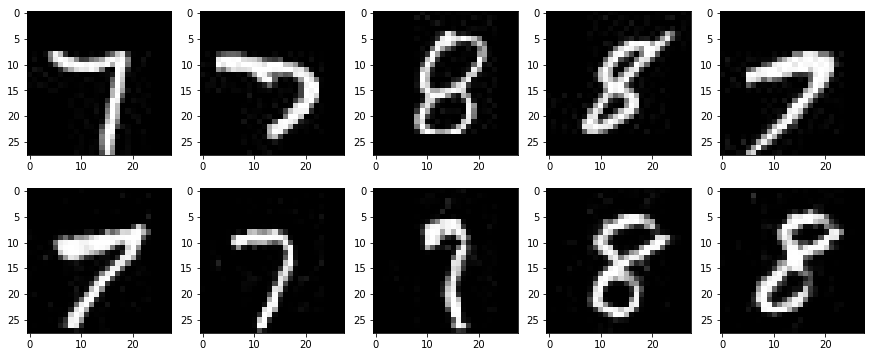

In [ ]:
# 生成画像と訓練データを可視化する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')


# テスト画像で異常検知する

In [ ]:
# テスト用のDataLoaderの作成


def make_test_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(5):
        img_path = "./data/test_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


# ファイルリストを作成
test_img_list = make_test_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)


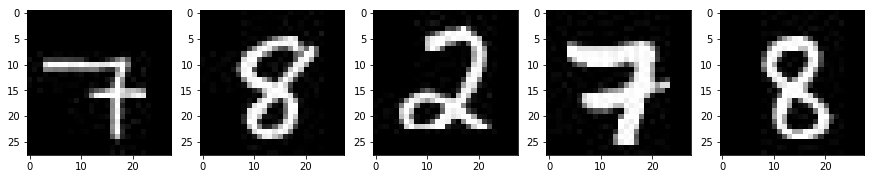

In [ ]:
# テストデータの確認
batch_iterator = iter(test_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')


In [ ]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):

    # テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値を求めて、ミニバッチごとに和を求める
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    # テスト画像xと生成画像fake_imgを識別器Dに入力し、特徴量マップを取り出す

    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)

    # テスト画像xと生成画像fake_imgの特徴量の差の絶対値を求めて、ミニバッチごとに和を求める
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(
        discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    # ミニバッチごとに2種類の損失を足し算する
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss


total loss： [171. 205. 285. 190. 161.]


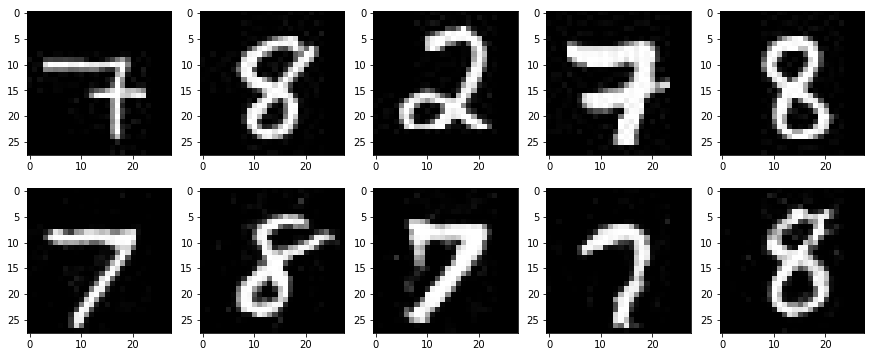

In [ ]:
# 異常検知したい画像
x = imges[0:5]
x = x.to(device)

# 教師データの画像をエンコードしてzにしてから、Gで生成
E_update.eval()
G_update.eval()
z_out_real = E_update(imges.to(device))
imges_reconstract = G_update(z_out_real)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    x, imges_reconstract, z_out_real, D_update, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

# 画像を可視化
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i][0].cpu().detach().numpy(), 'gray')


以上